In [1]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = True
AUGMENT_FRACTION = 0.3
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 18000
Dimensione del dataset combinato: 78000


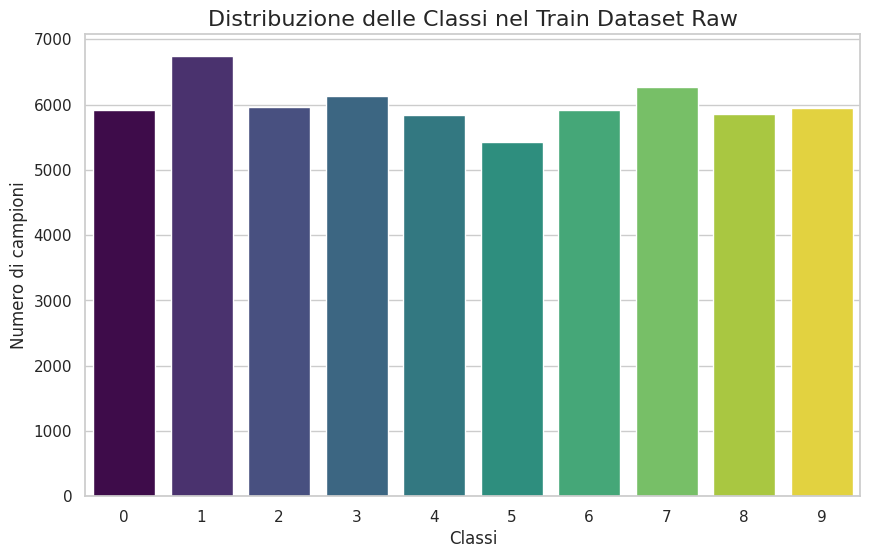

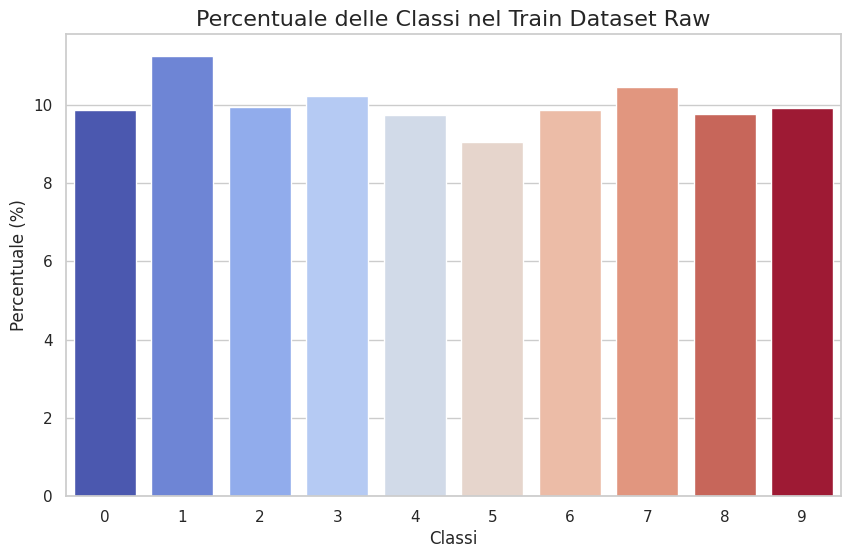

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 78000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 26045, 1: 25887, 2: 26068}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 26045 campioni (33.39%)
Relazione 1: 25887 campioni (33.19%)
Relazione 2: 26068 campioni (33.42%)




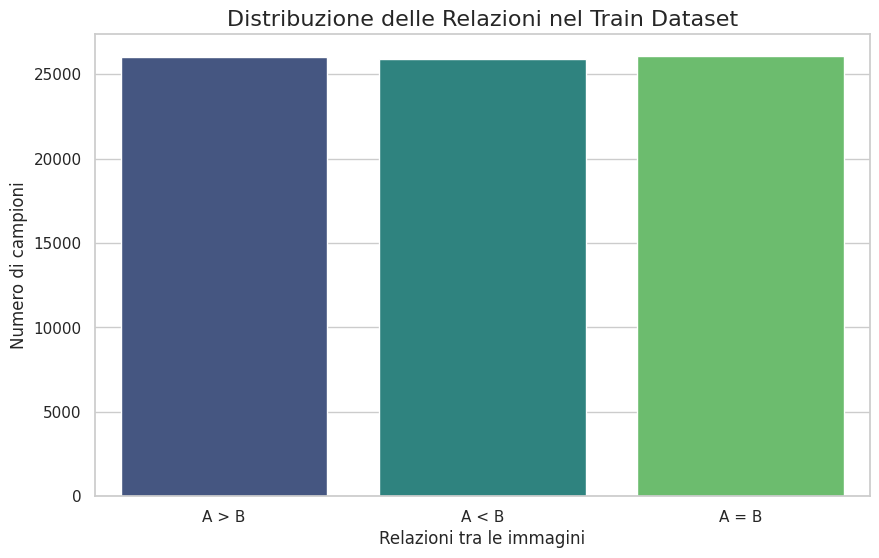

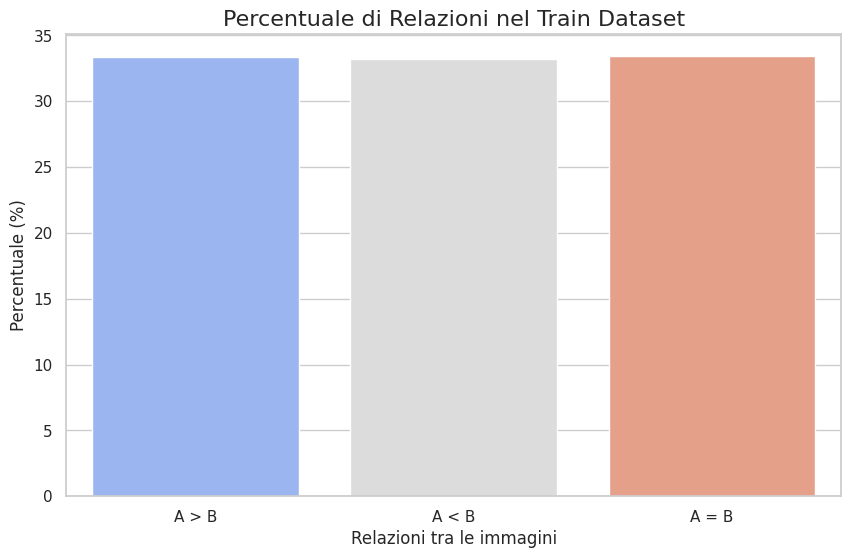

In [4]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 979, 0: 986, 1: 1035}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 2: 979 campioni (32.63%)
Relazione 0: 986 campioni (32.87%)
Relazione 1: 1035 campioni (34.50%)




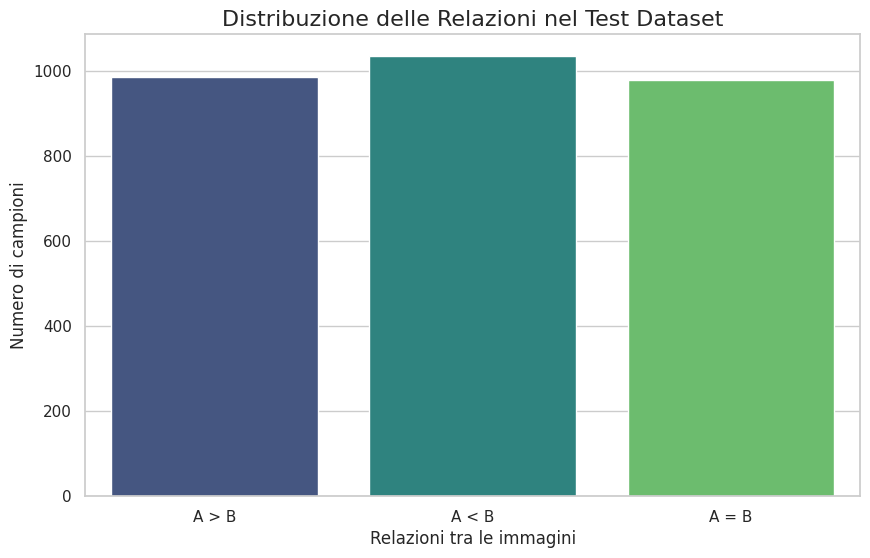

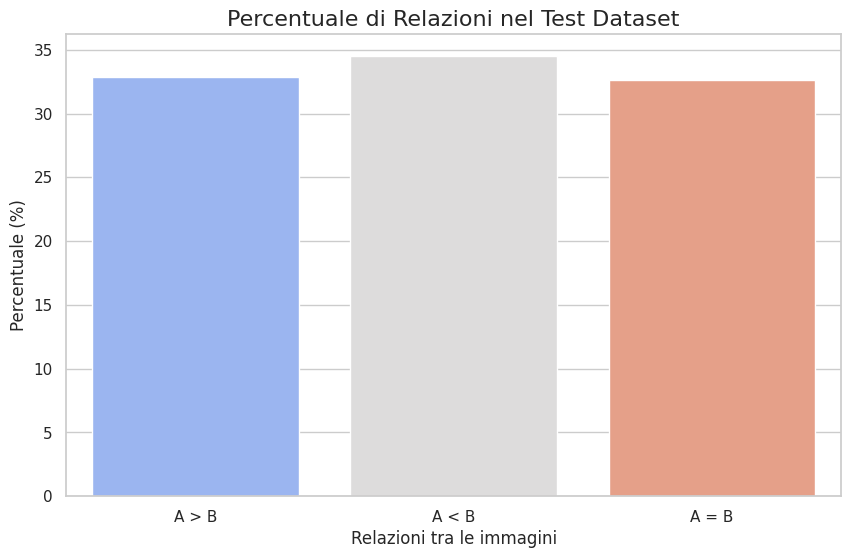

In [5]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2347, 1: 2298, 2: 2354}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2347 campioni (33.53%)
Relazione 1: 2298 campioni (32.83%)
Relazione 2: 2354 campioni (33.63%)




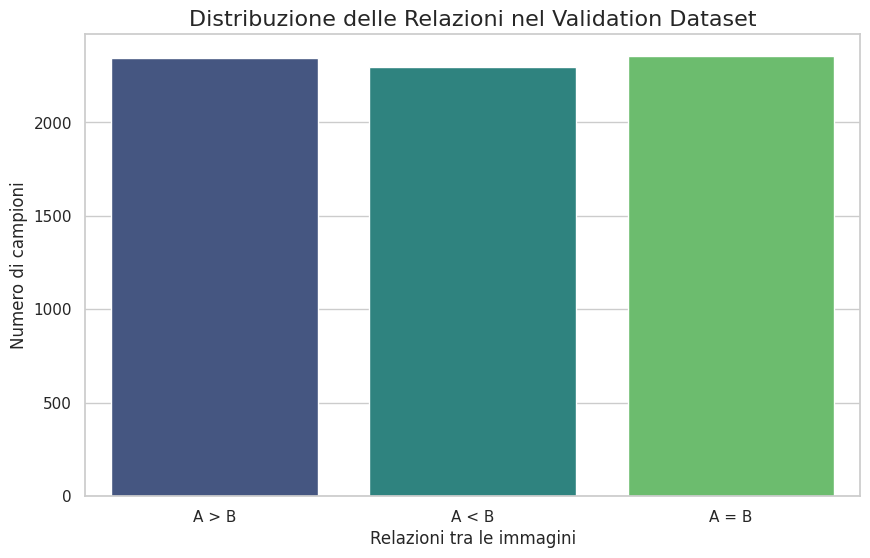

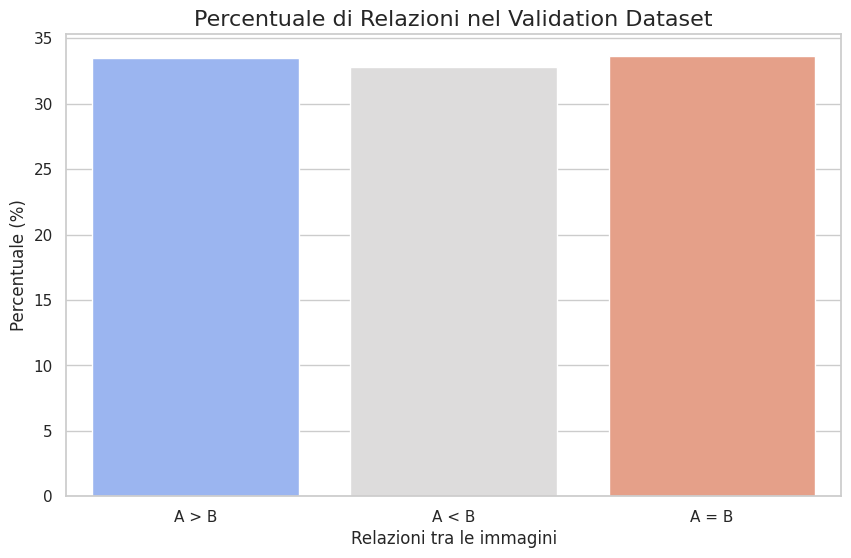

In [6]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [7]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [8]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  610  Size train_dataset:  78000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [11]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

images dtype: torch.float32, labels dtype: torch.int64


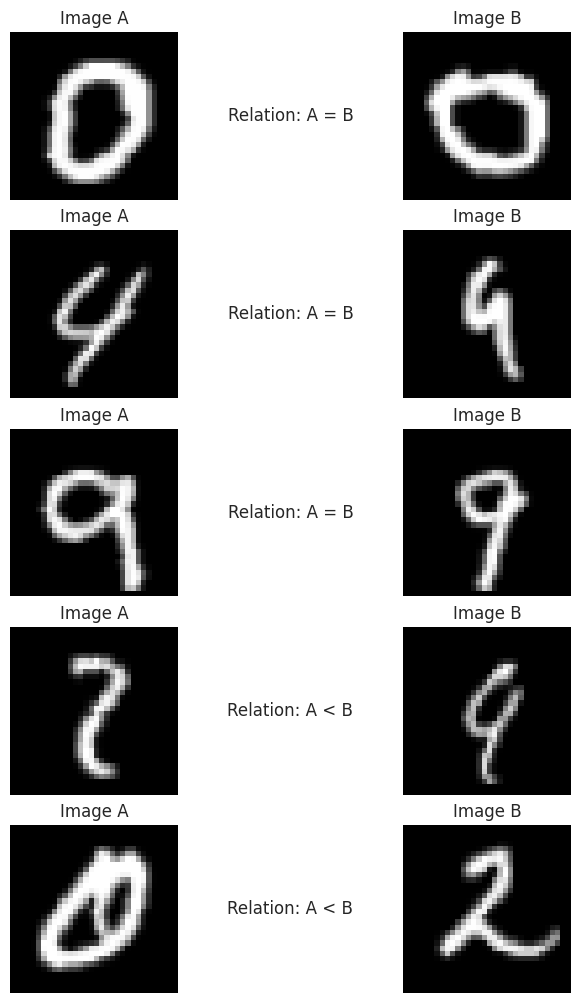

In [12]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [13]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [14]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


Loss: 0.4349: 100%|██████████| 610/610 [00:13<00:00, 43.75it/s]


Validating


Loss: 0.4477: 100%|██████████| 55/55 [00:00<00:00, 96.96it/s] 


Epoch #1 train loss: 0.719 train accuracy: 67.07
Epoch #1 validation loss: 0.448 validation accuracy: 82.74
Learning rate actual:  0.0009972609476841367
Took 0.242 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.3061: 100%|██████████| 610/610 [00:14<00:00, 43.47it/s]


Validating


Loss: 0.3598: 100%|██████████| 55/55 [00:00<00:00, 91.33it/s]


Epoch #2 train loss: 0.484 train accuracy: 79.19
Epoch #2 validation loss: 0.360 validation accuracy: 89.26
Learning rate actual:  0.0009890738003669028
Took 0.244 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.4589: 100%|██████████| 610/610 [00:13<00:00, 44.26it/s]


Validating


Loss: 0.3318: 100%|██████████| 55/55 [00:00<00:00, 97.15it/s] 


Epoch #3 train loss: 0.387 train accuracy: 83.87
Epoch #3 validation loss: 0.332 validation accuracy: 91.81
Learning rate actual:  0.0009755282581475768
Took 0.239 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.1496: 100%|██████████| 610/610 [00:13<00:00, 43.63it/s]


Validating


Loss: 0.2728: 100%|██████████| 55/55 [00:00<00:00, 98.52it/s]


Epoch #4 train loss: 0.326 train accuracy: 86.36
Epoch #4 validation loss: 0.273 validation accuracy: 93.48
Learning rate actual:  0.0009567727288213003
Took 0.242 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.1728: 100%|██████████| 610/610 [00:13<00:00, 44.65it/s]


Validating


Loss: 0.2386: 100%|██████████| 55/55 [00:00<00:00, 96.47it/s] 


Epoch #5 train loss: 0.283 train accuracy: 88.23
Epoch #5 validation loss: 0.239 validation accuracy: 94.11
Learning rate actual:  0.0009330127018922195
Took 0.237 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.2266: 100%|██████████| 610/610 [00:13<00:00, 44.41it/s]


Validating


Loss: 0.2200: 100%|██████████| 55/55 [00:00<00:00, 95.57it/s] 


Epoch #6 train loss: 0.249 train accuracy: 89.86
Epoch #6 validation loss: 0.220 validation accuracy: 94.03
Learning rate actual:  0.0009045084971874739
Took 0.239 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.2642: 100%|██████████| 610/610 [00:13<00:00, 44.52it/s]


Validating


Loss: 0.1404: 100%|██████████| 55/55 [00:00<00:00, 89.22it/s]


Epoch #7 train loss: 0.224 train accuracy: 90.95
Epoch #7 validation loss: 0.140 validation accuracy: 94.63
Learning rate actual:  0.0008715724127386972
Took 0.239 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.2561: 100%|██████████| 610/610 [00:16<00:00, 37.62it/s]


Validating


Loss: 0.1654: 100%|██████████| 55/55 [00:00<00:00, 87.55it/s]


Epoch #8 train loss: 0.202 train accuracy: 91.94
Epoch #8 validation loss: 0.165 validation accuracy: 94.74
Learning rate actual:  0.0008345653031794292
Took 0.281 minutes for epoch 8
No improvement for 1 epoch(s).
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.2699: 100%|██████████| 610/610 [00:16<00:00, 36.81it/s]


Validating


Loss: 0.1624: 100%|██████████| 55/55 [00:00<00:00, 79.29it/s]


Epoch #9 train loss: 0.184 train accuracy: 92.68
Epoch #9 validation loss: 0.162 validation accuracy: 95.00
Learning rate actual:  0.0007938926261462366
Took 0.288 minutes for epoch 9
No improvement for 2 epoch(s).
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.1064: 100%|██████████| 610/610 [00:16<00:00, 37.20it/s]


Validating


Loss: 0.1698: 100%|██████████| 55/55 [00:00<00:00, 84.84it/s]


Epoch #10 train loss: 0.166 train accuracy: 93.44
Epoch #10 validation loss: 0.170 validation accuracy: 95.13
Learning rate actual:  0.00075
Took 0.284 minutes for epoch 10
No improvement for 3 epoch(s).
Early stopping triggered after 10 epochs.
Checkpoint saved at epoch 10.
Validating


Loss: 0.3032: 100%|██████████| 24/24 [00:00<00:00, 74.15it/s]

Test loss: 0.303 Test accuracy: 95.27


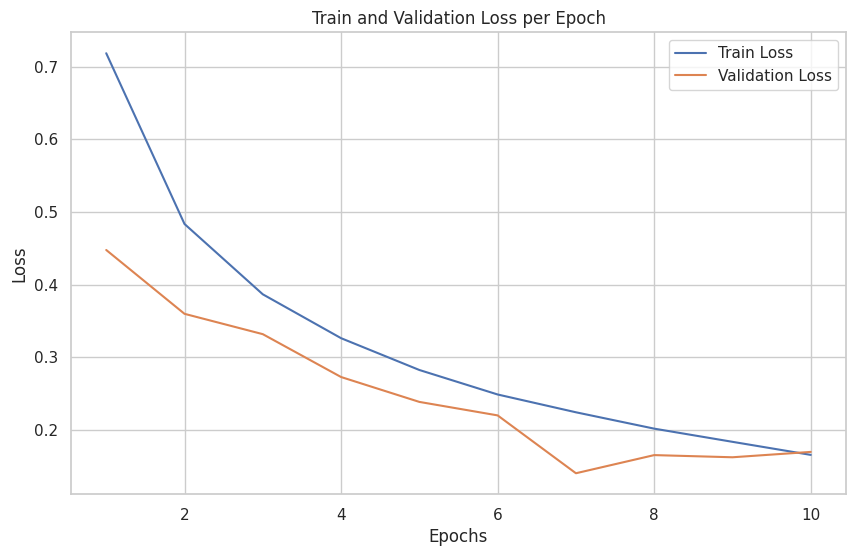

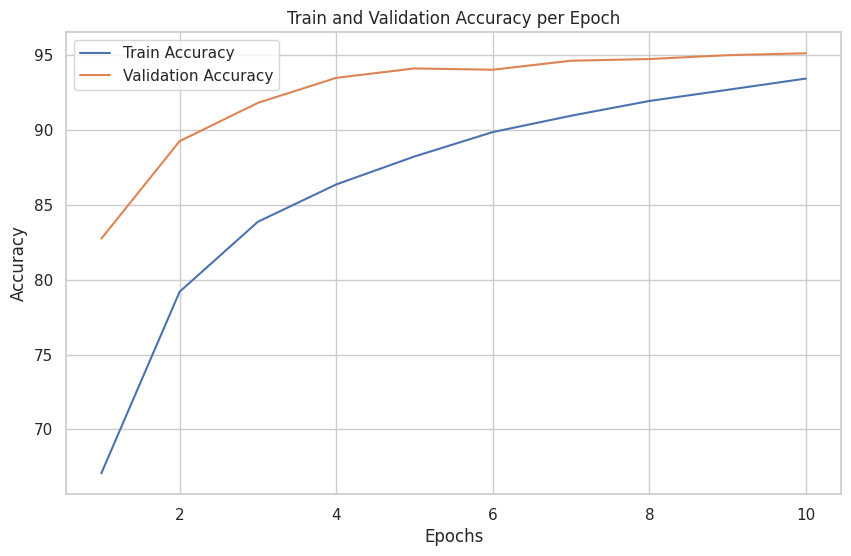

In [15]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

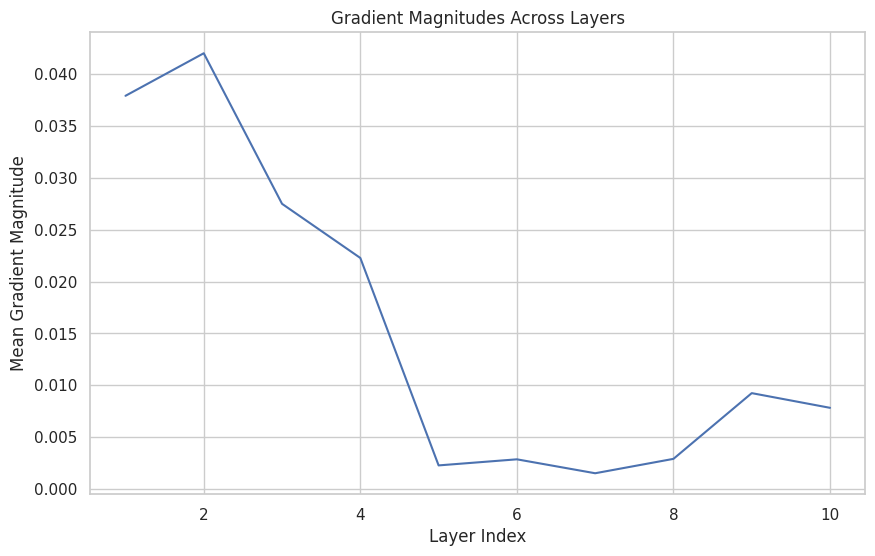

In [16]:
utils.plot_gradient(model)

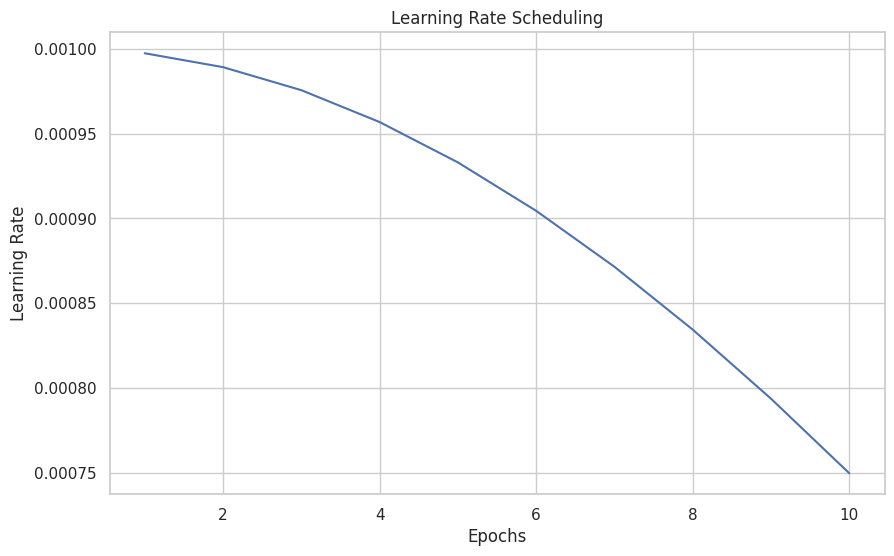

In [17]:
utils.plot_lr_scheduler(lr_history)

In [18]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

341 previsioni errate trovate.


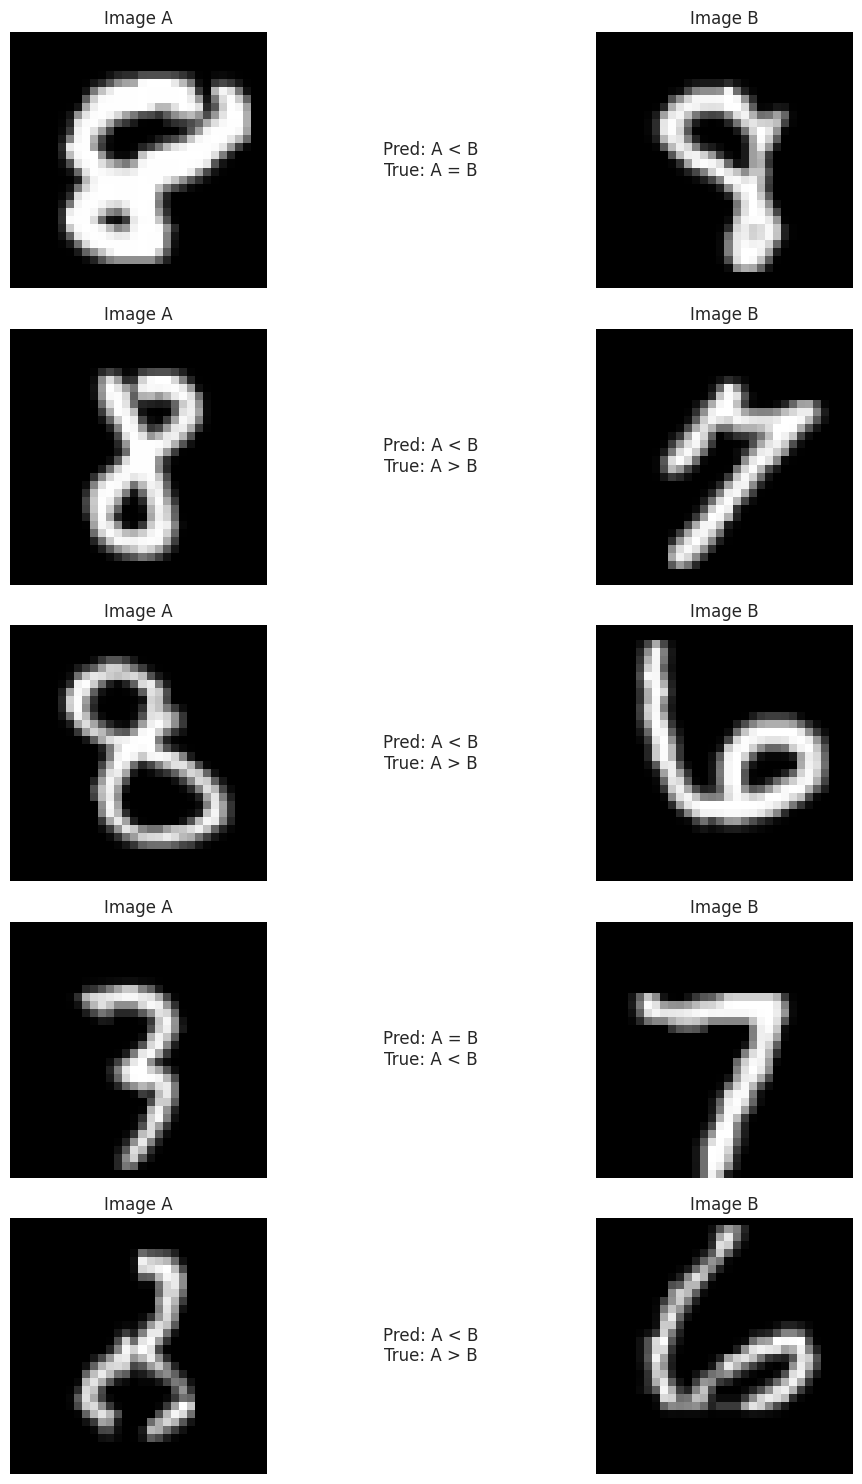

In [19]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

142 previsioni errate trovate.


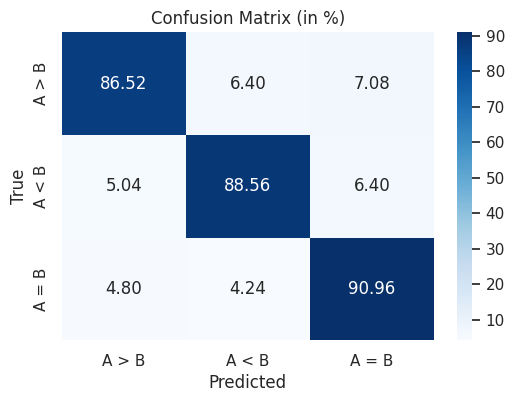

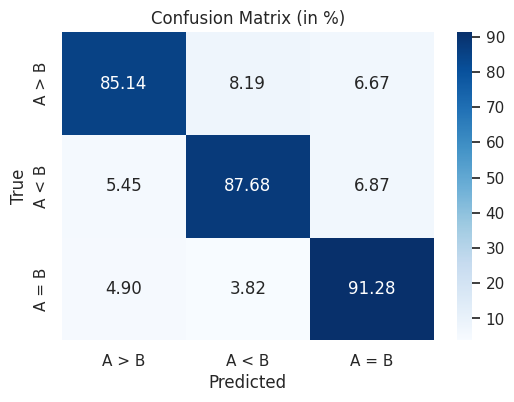

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.89      0.85      0.87       989
       A < B       0.88      0.88      0.88       990
       A = B       0.87      0.91      0.89      1021

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32.ipynb')


Notebook saved as run32x32_BS=128_LR=0.0001_EPOCHS=30_AUG=False_TRA=False_OPT=ADAM.ipynb


In [ ]:
writer.close()